In [1]:
import jax
import jax.numpy as np
import diffrax as dfx
import equinox as eqx
import musdb
import matplotlib.pyplot as plt
import random
import time

from model.audio_demixer_control import AudioDemixer as AudioDemixerCDE
from model.audio_demixer_forced import AudioDemixer as AudioDemixerODE
from model.update_first_order_control import Func as Func_1ord_CDE
from model.update_second_order_control import Func as Func_2ord_CDE
from model.update_first_order_forced import Func as Func_1ord_ODE
from model.update_second_order_forced import Func as Func_2ord_ODE
from trainer import Trainer

2024-04-18 14:38:12.764696: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 14:38:12.764724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 14:38:12.765767: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 14:38:13.834071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load the dataset
- We are using the musdb18 dataset, and associated python wrapper
- download it from here: ```https://sigsep.github.io/datasets/musdb.html#musdb18-compressed-stems```

[[1.47705078e-02 3.02124023e-03]
 [3.26538086e-02 1.63879395e-02]
 [5.39550781e-02 3.79028320e-02]
 ...
 [0.00000000e+00 0.00000000e+00]
 [3.05175781e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00]]


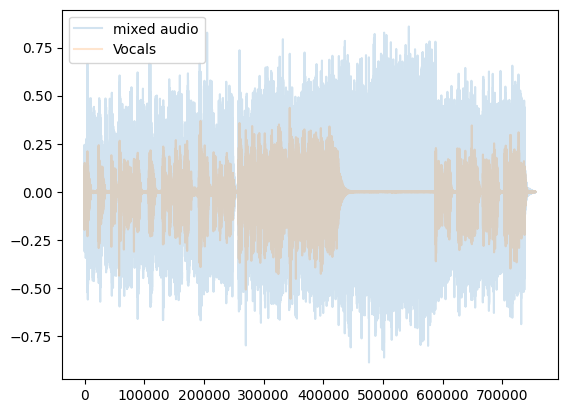

In [2]:
mus = musdb.DB(root="../Data/musdb18/")
print(mus[0].audio)
plt.plot(mus[0].audio[::10,0],alpha=0.2,label="mixed audio")
plt.plot(mus[0].targets["vocals"].audio[::10,0],alpha=0.2,label="Vocals")
plt.legend()
plt.show()



# Import the models from ```model/``` directory
 - the ```update``` term is a function of the form ```(t,y,args)->y``` that defines the RHS of the system of differential equations
    - Neural networks are defined via the Equinox library
 - the ```model``` term is a function of the form ```(ts,h0,xs)->(ts,hs,ys)``` that wraps the ```update``` term in an auto-differentiable numerical solver for a differential equation
    - Numerical solvers defined in the Diffrax library
 - The update functions are of the following forms:
## 1st order control differential equation (CDE) ```Func_1ord_CDE```:

$\frac{dh(t)}{dt} = \big[G\big(h(t),t\big)\odot \big[F\big(h(t),t\big)-h(t)\big]\big]\frac{dx}{dt}$

$y(t) = H\big(h(t),t\big)$

## 1st order forced ODE ```Func_1ord_ODE```:

$\frac{dh(t)}{dt} = G\big(h(t),x(t),t\big)\odot \big[F\big(h(t),x(t),t\big) - h(t)\big]$

$y(t) = H\big(h(t),x(t),t\big)$

## 2nd order CDE ```Func_2ord_CDE```:

$\frac{dh(t)}{dt}= v(t)\frac{dx(t)}{dt}$

$\frac{dv(t)}{dt}=-\Big[\underbrace{v(t)\odot G\Big(h(t),v(t)\Big)\odot F_1\Big(h(t),v(t)\Big)}_{\text{damping}} + \underbrace{h(t)\odot F_2\Big(h(t),v(t)\Big)}_{\text{restoring force}}\Big]\frac{dx(t)}{dt}$

$y(t) = H(h(t),v(t))$

## 2nd order forced ODE ```Func_2ord_ODE```:

$\frac{dh(t)}{dt}= v(t)$

$\frac{dv(t)}{dt}=-\Big[\underbrace{v(t)\odot G\Big(h(t),v(t),x(t)\Big)\odot F_1\Big(h(t),v(t),x(t)\Big)}_{\text{damping}} + \underbrace{h(t)\odot F_2\Big(h(t),v(t),x(t)\Big)}_{\text{restoring force}}\Big]$

$y(t) = H(h(t),v(t))$


In [3]:
latent_size = 128
update = Func_1ord_ODE(channels=2,latent_size=latent_size)
model = AudioDemixerODE(update)

# Lets run a randomly initialised model to see what happens
- We choose a random 1 second snippet from a song and run the model on that

In [4]:
LENGTH=1.0

track = mus.tracks[10]
track.chunk_duration = LENGTH
track.chunk_start = random.uniform(0, track.duration - track.chunk_duration)
xs = track.audio
y_true = track.targets["vocals"].audio

N = len(xs)
ts = np.linspace(0,N,N)
y0 = jax.random.normal(key=jax.random.PRNGKey(int(time.time())),shape=(latent_size,))

_,hs,ys = model(ts,y0,xs)

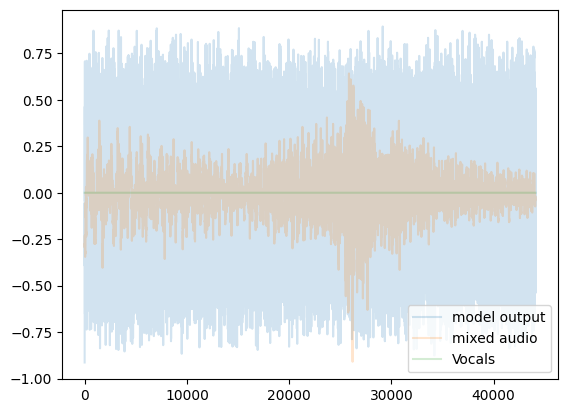

In [5]:
plt.plot(ts,ys[:,0],alpha=0.2,label="model output") # Just left channel
plt.plot(ts,xs[:,0],alpha=0.2,label="mixed audio")
plt.plot(ts,y_true[:,0],alpha=0.2,label="Vocals")
plt.legend()
plt.show()

# Repeat but with a CDE rather than ODE
 - Controlled Differential Equations (CDEs) are a different way of handling inputs to dynamical systems
 - It is worth comparing the outputs of randomly initialised CDEs and ODEs, to understand the different sorts of behaviours they typically capture
 - Note that CDEs only handle mono audio, so we average over left and right channels

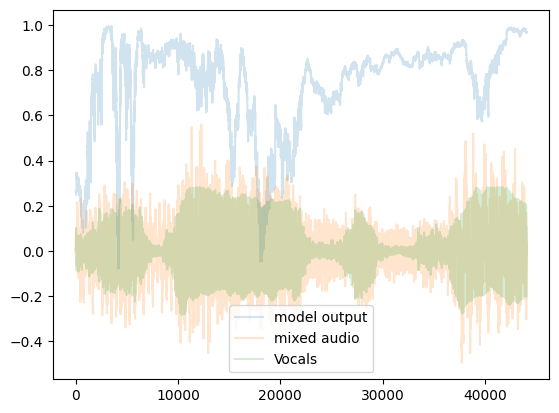

In [6]:
latent_size = 128
update = Func_1ord_CDE(channels=1,latent_size=latent_size)
model = AudioDemixerCDE(update)
LENGTH=1.0

track = mus.tracks[10]
track.chunk_duration = LENGTH
track.chunk_start = random.uniform(0, track.duration - track.chunk_duration)
xs = np.mean(track.audio,axis=1)
y_true = np.mean(track.targets["vocals"].audio,axis=1)
N = len(xs)
ts = np.linspace(0,N,N)
y0 = jax.random.normal(key=jax.random.PRNGKey(int(time.time())),shape=(latent_size,))

_,hs,ys = model(ts,y0,xs)
plt.plot(ts,ys,alpha=0.2,label="model output") # Just left channel
plt.plot(ts,xs,alpha=0.2,label="mixed audio")
plt.plot(ts,y_true,alpha=0.2,label="Vocals")
plt.legend()
plt.show()

# Training
- The imported ```Trainer``` class handles both CDEs and ODEs with the ```MODE``` flag, with ```MODE=0``` for CDEs and ```MODE=1``` for ODEs
- Here we train on a random selection of 8 snippets of audio, 0.01 seconds long (for sake of fast training time)
- Data loading is slow compared to model computation, so we keep the same minibatch for $n=100$ training iterations

In [17]:
update = Func_1ord_CDE(channels=1,latent_size=latent_size)
model = AudioDemixerCDE(update)
T = Trainer(model,"../Data/musdb18",filename="audemix_1",BATCHES=8,LENGTH=0.01,MODE=0)
model_trained,loss = T.train(100)

100%|██████████| 100/100 [05:34<00:00,  3.34s/it]


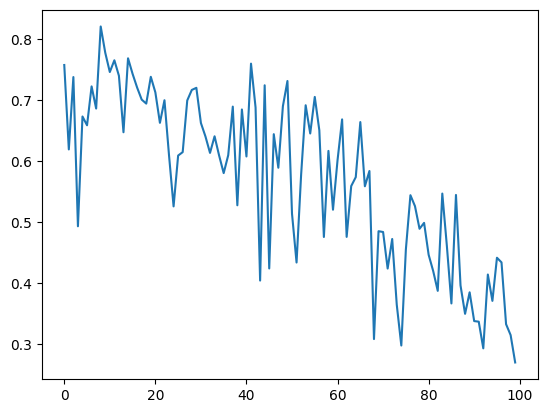

In [18]:
plt.plot(loss)
plt.show()

## Is the trained model any good...?
 - not yet, definitely needs better training

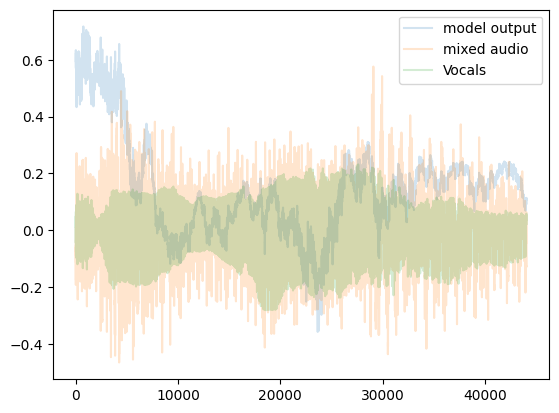

In [22]:
model = AudioDemixerCDE(update)
model = model.load("models/audemix_1.eqx")
track = mus.tracks[10]
track.chunk_duration = LENGTH
track.chunk_start = random.uniform(0, track.duration - track.chunk_duration)
xs = np.mean(track.audio,axis=1)
y_true = np.mean(track.targets["vocals"].audio,axis=1)
N = len(xs)
ts = np.linspace(0,N,N)
y0 = jax.random.normal(key=jax.random.PRNGKey(int(time.time())),shape=(latent_size,))

_,hs,ys = model(ts,y0,xs)
plt.plot(ts,ys,alpha=0.2,label="model output") # Just left channel
plt.plot(ts,xs,alpha=0.2,label="mixed audio")
plt.plot(ts,y_true,alpha=0.2,label="Vocals")
plt.legend()
plt.show()


## Lets test a model that was trained for longer on a gpu:
- 1000 training iterations, minibatches of 128 0.01 second snippets with a latent size of 1024
- Still doesn't perform great
    - Longer audio samples are probably needed fro training, but that gets expensive to train to

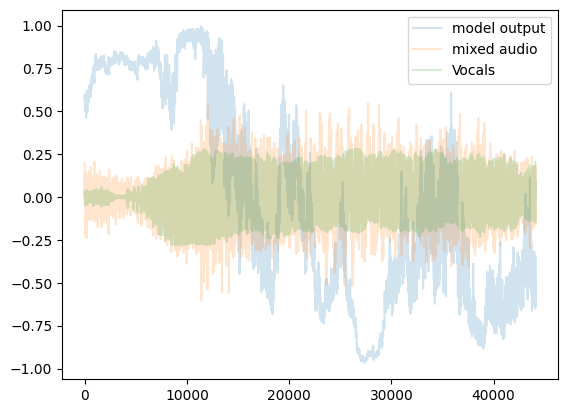

In [16]:
update_better = Func_1ord_CDE(1,latent_size=1024)
model_better = AudioDemixerCDE(update_better)
model_better = model_better.load("models/audemix_1ord_control_2.eqx")
track = mus.tracks[10]
track.chunk_duration = LENGTH
track.chunk_start = random.uniform(0, track.duration - track.chunk_duration)
xs = np.mean(track.audio,axis=1)
y_true = np.mean(track.targets["vocals"].audio,axis=1)
N = len(xs)
ts = np.linspace(0,N,N)
y0 = jax.random.normal(key=jax.random.PRNGKey(int(time.time())),shape=(latent_size,))

_,hs,ys = model(ts,y0,xs)
plt.plot(ts,ys,alpha=0.2,label="model output") # Just left channel
plt.plot(ts,xs,alpha=0.2,label="mixed audio")
plt.plot(ts,y_true,alpha=0.2,label="Vocals")
plt.legend()
plt.show()